# Zonal Statistics

## Overview

The Zonal Statistics function presents the results as a table and summarises the values of a raster within the zones of another dataset.

The aim of this tutorial is to extract the total precipitaion for each county in the state of California, USA.  2021 dataset.

Input Layers:

* `chirps-v2.0.2021.tif`: Raster grid of precipitaion for 2021  by Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS).
*  `cb_2021_us_county_500k.zip`: A vector file with polygons representing counties  in the US.

Output Layers:

*   `precipitation.gpkg` : A GeoPackage containing a vector layer of county polygon with total precipitaion values sampled from the raster.


Data Credit:

*   [CHIRPS 2021 precipitation](https://data.chc.ucsb.edu/products/CHIRPS-2.0/). Climate Hazards Center (CHC). Retrieved 2022-09

*   [US Census files: 2021](https://www2.census.gov/geo/tiger/GENZ2021/) United States Census Bureau. Retrieved 2022-09.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !apt install libspatialindex-dev
    !pip install fiona shapely pyproj rtree
    !pip install geopandas
    !pip install rioxarray
    !pip install geocube
    !pip install xarray_spatial

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube
from xrspatial.zonal import stats


In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

raster_file = 'chirps-v2.0.2021.tif'
zones_file = 'cb_2021_us_county_500k.zip'

files = [
    'https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_annual/tifs/' + raster_file,
    'https://www2.census.gov/geo/tiger/GENZ2021/shp/' + zones_file,
]

for file in files:
  download(file)

# Data Pre-Processing

First we will read the  Zipped counties shapefile and filter out the counties that are in `California` state.

The dataframe has a column  as `STATE_NAME` having naesm of states that can be used to filter the counties for *California*.

In [ ]:
zones_file_path = os.path.join(data_folder, zones_file)

zones_df = gpd.read_file(zones_file_path)
california_df  = zones_df[zones_df['STATE_NAME'] == 'California'].copy()
california_df

The 'GEOID' column contains a unique id for all the counties present in the state, but it is of `object` type. We need to convert it to `int` type to be used in xarray.

Since the CHIRPS dataset is for whole world, so we clip it to the bounds of *California* state. Storing the values of bounding box in the required variables.   

 Now, read the raster file using `rioxarray` and clip it to the geometry of *California* state.

In [ ]:
raster_filepath = os.path.join(data_folder, raster_file)
raster = rxr.open_rasterio(raster_filepath, mask_and_scale=True).rio.clip(california_df.geometry)
raster

You will notice that the raster has many pixels with value -9999. These are NoData values but they are not encoded as such. We will mask these values to get only the valid pixels.

The raster has only 1 band containing yearly precipitaion values, so we select it.

In [ ]:
precipitation = raster.sel(band=1)
precipitation

## Sampling Raster Values

Now we will extract the value of the raster pixels for every counties in California. We will be uisng `geocube` module for that. It takes geodataframe, it's unique value as integer and a xarray dataset as input and converts the geodataframe into  a `xarray dataset` having dimension and coordinates same as of given input xarray dataset


In [ ]:
california_df['GEOID'] = california_df.GEOID.astype(int)
california_raster = make_geocube(
    vector_data=california_df,
    measurements=['GEOID'],
    like=precipitation,
)
california_raster

In [ ]:
stats_df = stats(zones=california_raster.GEOID, values=precipitation)
stats_df

In [ ]:
stats_df['GEOID'] = stats_df['zone'].astype(int)
joined = california_df.merge(stats_df[['GEOID', 'mean']], on='GEOID')
joined

Plotting the average annual precipitation for the California state.

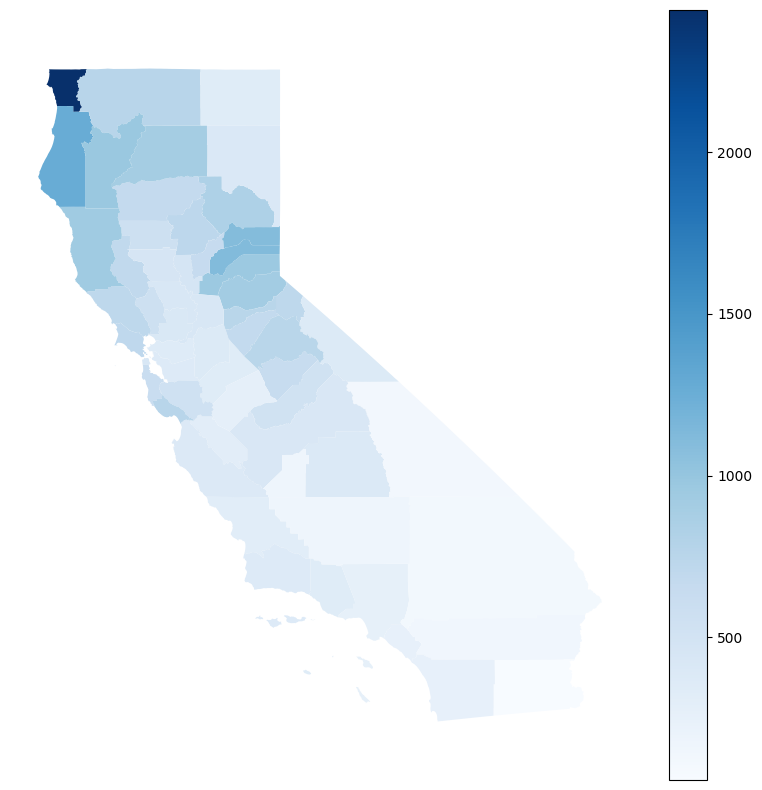

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
joined.plot(ax=ax, column='mean', cmap='Blues',
          legend = True)
ax.set_axis_off()
plt.show()

Finally, we save the sampled result to disk as `.gpkg`.

In [ ]:
output_file = 'precipitation_by_county.gpkg'
output_path = os.path.join(output_folder, output_file)

joined.to_file(driver = 'GPKG', filename =output_path)
print('Successfully written output file at {}'.format(output_path))